# 🎬 Phase 2 Project — Movie Studio 

**Authors:** 


## 1. Overview

**Business Context:** Our company plans to launch a new **movie studio** and needs guidance on **what types of films** to make for the box office.  
**Goal:** Use EDA on movie datasets to understand **genres, budgets, grosses, and ratings** and provide **actionable recommendations**.

**Objectives/Questions:**  
1. Which genres are **most expensive** to produce?  
2. Which genres are **best performing** by total **worldwide gross**?  
3. What is the **effect of production budget** on **profit**?  
4. How do **audience ratings** relate to performance?  

## 2. Business Problem

Our company is creating a new **movie studio** but has limited expertise. We must analyze relevant datasets and translate findings into **specific business recommendations** for the studio leadership.

## 3. Data Understanding

**Data Sources:**  
- **The Numbers (TN)** — production budgets & grosses  
- **Box Office Mojo (BOM)** — grosses  
- **IMDB (SQLite)** — titles, genres, ratings (`average_rating`), and votes (`num_votes`)  
- _Optional_: Rotten Tomatoes / TheMovieDB for critic or metadata signals (if included)

**File Layout:**  
- `./Data/bom.movie_gross.csv`  
- `./Data/tn.movie_budgets.csv`  
- `./im.db/im.db` (SQLite with `movie_basics`, `movie_ratings`, possibly `movie_akas`)

## 4. Data Loading & Inspection

In [1]:
#Importing
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# 1. Loading the Box Office Mojo (CSV) file 
bom = pd.read_csv("./Data/bom.movie_gross.csv")
bom.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [3]:
bom.shape

(3387, 5)

In [4]:
#2. Loading budgets and grosses
tn = pd.read_csv("./Data/tn.movie_budgets.csv")
tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [5]:
tn.shape

(5782, 6)

In [6]:
#3. Connecting to the IMDB database 
conn = sqlite3.connect("./im.db/im.db")
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [7]:
movie_basics  = pd.read_sql("SELECT * FROM movie_basics;", conn)
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [8]:
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)
movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [9]:
conn.close()

## 5. Data Cleaning

*Plan:*  
- Convert TN monetary columns (`production_budget`, `domestic_gross`, `worldwide_gross`) from `"$123,456,789"` → numeric.  
- Create **`profit = worldwide_gross - production_budget`**.  
- Normalize titles (lowercase, strip, remove parentheses/punctuation).  
- Handle missing values.  
- Drop **exact duplicate rows**.  


*Cleaning the Budget and Gross Dataset*

In [10]:
#Cleaned copy
tn_clean = tn.copy()

In [11]:
#Displaying first five rows
tn_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [12]:
#Checking data types
tn_clean.dtypes

id                    int64
release_date         object
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [13]:
#Removing dollar signs ($) and commas (,) from money columns,
#Converting them from text to numbers (float type)
for col in ["production_budget", "domestic_gross", "worldwide_gross"]:
    tn_clean[col] = (
        tn_clean[col]
        .str.replace("$", "", regex=False)
        .str.replace(",", "", regex=False)
        .astype(float)
    )

In [14]:
#Re-checking data types
tn_clean.dtypes

id                     int64
release_date          object
movie                 object
production_budget    float64
domestic_gross       float64
worldwide_gross      float64
dtype: object

In [15]:
#Checking for null values
tn_clean.isna().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
dtype: int64

In [16]:
#Checking for duplicates
tn_clean.duplicated().value_counts()

False    5782
dtype: int64

In [17]:
#Creating a 'profit' column
# Profit = worldwide gross - production budget
tn_clean["profit"] = tn_clean["worldwide_gross"] - tn_clean["production_budget"]

In [18]:
#Cleaning up movie names to make them lowercase and tidy
tn_clean["movie"] = tn_clean["movie"].str.lower().str.strip()

In [19]:
tn_clean.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit
0,1,"Dec 18, 2009",avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08
2,3,"Jun 7, 2019",dark phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08
3,4,"May 1, 2015",avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09
4,5,"Dec 15, 2017",star wars ep. viii: the last jedi,317000000.0,620181382.0,1.316722e+09,9.997217e+08


In [20]:
tn_clean.describe()

,id,production_budget,domestic_gross,worldwide_gross,profit
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07,5.989970e+07
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08,1.460889e+08
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00,-2.002376e+08
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06,-2.189071e+06
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07,8.550286e+06
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07,6.096850e+07
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09,2.351345e+09


In [21]:
tn_clean.shape

(5782, 7)

In [22]:
#Creating a cleaned csv file
tn_clean.to_csv("cleaned-tn.movies_budgets.csv", index=False)

*Loading and Cleaning IMDB Data*

In [23]:
#Connecting to the IMDB database
conn = sqlite3.connect("./im.db/im.db")

In [24]:
#Reading only the columns we need from the two main tables
movie_basics = pd.read_sql("SELECT primary_title, start_year, genres FROM movie_basics;", conn)
movie_ratings = pd.read_sql("SELECT * FROM movie_ratings;", conn)

In [25]:
#Closing the connection
conn.close()

In [26]:
#Clean movie titles
movie_basics["primary_title"] = movie_basics["primary_title"].str.lower().str.strip()

In [27]:
movie_basics.head()

,primary_title,start_year,genres
0,sunghursh,2013,"Action,Crime,Drama"
1,one day before the rainy season,2019,"Biography,Drama"
2,the other side of the wind,2018,Drama
3,sabse bada sukh,2018,"Comedy,Drama"
4,the wandering soap opera,2017,"Comedy,Drama,Fantasy"


In [28]:
#Checking for null values
movie_basics.isna().sum()

primary_title       0
start_year          0
genres           5408
dtype: int64

In [29]:
movie_basics.shape

(146144, 3)

In [30]:
#Checking the missing values in terms of percentages
a = movie_basics.shape

nan_percent = (movie_basics.isna().sum() / a[0])*100 # total percent of missing values per column
nan_percent

primary_title    0.00000
start_year       0.00000
genres           3.70046
dtype: float64

In [31]:
#Replacing any missing genres with "Unknown"
movie_basics["genres"] = movie_basics["genres"].fillna("Unknown")

In [32]:
#Displaying first five rows for movie_basics
movie_basics.head()

,primary_title,start_year,genres
0,sunghursh,2013,"Action,Crime,Drama"
1,one day before the rainy season,2019,"Biography,Drama"
2,the other side of the wind,2018,Drama
3,sabse bada sukh,2018,"Comedy,Drama"
4,the wandering soap opera,2017,"Comedy,Drama,Fantasy"


# 6. Data Preparation (Merging)

*Merging TN and IMDB Data*

In [33]:
# Making sure both title columns are lowercase and tidy
tn_clean["movie"] = tn_clean["movie"].str.lower().str.strip()
movie_basics["primary_title"] = movie_basics["primary_title"].str.lower().str.strip()

In [34]:
# Merging using movie title as the key
merged = pd.merge(
    tn_clean,
    movie_basics,
    left_on="movie",
    right_on="primary_title",
    how="inner"   # keeps only movies that appear in both datasets
)

In [35]:
merged.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,primary_title,start_year,genres
0,1,"Dec 18, 2009",avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,avatar,2011,Horror
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,pirates of the caribbean: on stranger tides,2011,"Action,Adventure,Fantasy"
2,3,"Jun 7, 2019",dark phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,dark phoenix,2019,"Action,Adventure,Sci-Fi"
3,4,"May 1, 2015",avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,avengers: age of ultron,2015,"Action,Adventure,Sci-Fi"
4,7,"Apr 27, 2018",avengers: infinity war,300000000.0,678815482.0,2.048134e+09,1.748134e+09,avengers: infinity war,2018,"Action,Adventure,Sci-Fi"


Merging the new merge with movie ratings by title

In [36]:
#Connecting to the IMDB database
conn = sqlite3.connect("./im.db/im.db")

In [37]:
#This line runs an SQL query directly on the SQLite database to get movie_id, 
# primary_title, and start_year columns from the movie_basics table.
movie_basics2 = pd.read_sql_query(
    "SELECT movie_id, primary_title, start_year FROM movie_basics;",
    conn
)
#Merges the movie ratings table with movie_basics2, matching them by the movie_id column.
#how="left" keeps all rows from movie_ratings, adding title and year info where a match is found.
ratings_with_titles = movie_ratings.merge(movie_basics2, on="movie_id", how="left")

merged_by_title = pd.merge(
    merged,
    ratings_with_titles[['primary_title', 'start_year', 'averagerating', 'numvotes']].drop_duplicates(),
    on=['primary_title', 'start_year'],
    how='left'
)

merged_by_title.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,profit,primary_title,start_year,genres,averagerating,numvotes
0,1,"Dec 18, 2009",avatar,425000000.0,760507625.0,2.776345e+09,2.351345e+09,avatar,2011,Horror,NaN,NaN
1,2,"May 20, 2011",pirates of the caribbean: on stranger tides,410600000.0,241063875.0,1.045664e+09,6.350639e+08,pirates of the caribbean: on stranger tides,2011,"Action,Adventure,Fantasy",NaN,NaN
2,3,"Jun 7, 2019",dark phoenix,350000000.0,42762350.0,1.497624e+08,-2.002376e+08,dark phoenix,2019,"Action,Adventure,Sci-Fi",NaN,NaN
3,4,"May 1, 2015",avengers: age of ultron,330600000.0,459005868.0,1.403014e+09,1.072414e+09,avengers: age of ultron,2015,"Action,Adventure,Sci-Fi",NaN,NaN
4,7,"Apr 27, 2018",avengers: infinity war,300000000.0,678815482.0,2.048134e+09,1.748134e+09,avengers: infinity war,2018,"Action,Adventure,Sci-Fi",NaN,NaN


## 7. Analysis & Visualizations


### 7.1 Objective 1: Which genres are the most expensive to produce? 


In this analysis, we aim to determine which movie genres have the highest average production budgets using our merged movie dataset.
By understanding which genres are the most expensive, film studios can better plan their production investments.

*Step1: Load the Merged Dataset*

We begin by loading the merged dataset that contains both genre and production budget information.

In [38]:
# STEP 1: Prepare the data
df_genre = merged_by_title[['production_budget', 'genres']].dropna(subset=['genres', 'production_budget'])

*Step 2: Split Multi-Genre Entries*

Some movies in our dataset belong to multiple genres — for example, a movie might be listed as "Action, Adventure" or "Comedy, Drama".
If we leave them combined, each multi-genre movie will only count toward one category, which would distort the averages when calculating production budgets per genre.

To fix this, we split these combined genres into separate rows, ensuring each genre is analyzed individually.

In [39]:
# STEP 2: Split multi-genre entries
df_genre['genres'] = df_genre['genres'].str.split(',')# Split the genre string into a list
df_genre = df_genre.explode('genres')                 #create a new row for each genre
df_genre['genres'] = df_genre['genres'].str.strip()   #Remove extra spaces around genre names

*Step 3:Calculate Average and Count per Genre*

since each genre is separated into its own row, we can calculate how expensive each genre is to produce on average.
We’ll do this by grouping the dataset by genre and computing two key metrics:

The count → how many movies belong to that genre.
The mean → the average production budget for that genre.

In [40]:
# STEP 3: Calculate average and count per genre
genre_stats = (
    df_genre
    .groupby('genres')['production_budget'] #Groups all movies by genre focusing on production budget column.
    .agg(['count', 'mean'])   # Create two columns: count and mean
    .reset_index() #converts the grouped data back into a regular DataFrame
    .sort_values('mean', ascending=False)#sorting from most expensive to least expensive
)

*Step 4: Filtering of genres with very few Movies*

In this step, we make sure our results are fair. Some genres might look expensive only because they have a few movies. To fix this, we only keep genres that have 20 or more movies.

After that, we pick the top 15 genres with the highest average production cost. This helps us see which genres are truly the most expensive to make.

In [41]:
# STEP 4: Filter out genres with very few movies
min_count = 20
top_by_mean = genre_stats[genre_stats['count'] >= min_count].head(15)

print("Top 15 Most Expensive Genres (by Average Production Budget):")
display(top_by_mean)

Top 15 Most Expensive Genres (by Average Production Budget):


,genres,count,mean
1,Adventure,503,8.657323e+07
2,Animation,153,7.991089e+07
9,Fantasy,209,6.577390e+07
18,Sci-Fi,233,6.355628e+07
0,Action,726,6.183072e+07
8,Family,210,4.610358e+07
13,Musical,36,3.836498e+07
23,Western,26,3.748269e+07
4,Comedy,867,3.314778e+07
21,Unknown,73,3.299690e+07


*Step 5: Visualization of the Top 10 most expensive genres*

Using Seaborn’s bar plot, we visualized the Top 10 most expensive genres based on their average production budgets.

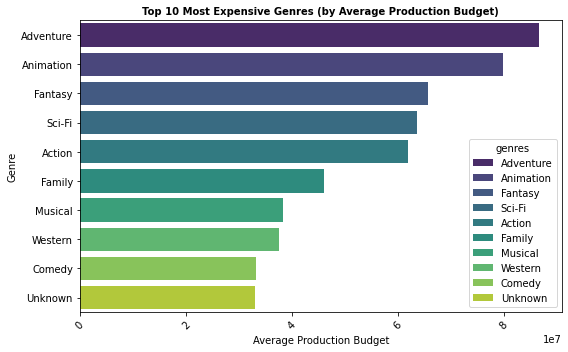

In [56]:
# Visualization — Top 10 most expensive genres
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_by_mean.head(10),
    x='mean',
    y='genres',
    hue='genres',         # Colors each genre
    palette='viridis',
    dodge=False,          # Keeps bars aligned
)

plt.title('Top 10 Most Expensive Genres (by Average Production Budget)', fontsize=10, weight='bold')
plt.xlabel('Average Production Budget')
plt.ylabel('Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 7.2 Objective 2 — Best Performing Genres (Total Gross)
**Question:** Which genres earn the highest total box-office gross?  
**Approach:** Group by `main_genre` → compute **total** `worldwide_gross`

In [43]:
# Make sure we have a single genre column (from Objective 1)
merged["main_genre"] = merged["genres"].fillna("Unknown").apply(lambda x: x.split(",")[0])

In [44]:
# Group by genre and calculate total and average worldwide gross
genre_gross = (
    merged.groupby("main_genre")[["worldwide_gross", "profit"]]
    .agg(total_gross=("worldwide_gross", "sum"),
         avg_gross=("worldwide_gross", "mean"),
         avg_profit=("profit", "mean"),
         movie_count=("profit", "count"))
    .sort_values("total_gross", ascending=False)
)

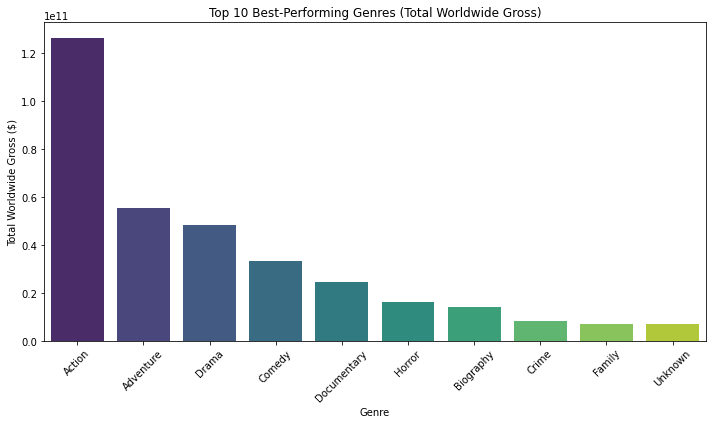

In [45]:
# Visualization – Top 10 Best-Performing Genres
plt.figure(figsize=(10,6))
sns.barplot(
    x=genre_gross.head(10).index,
    y=genre_gross.head(10)["total_gross"],
    palette="viridis"
)
plt.title("Top 10 Best-Performing Genres (Total Worldwide Gross)")
plt.xlabel("Genre")
plt.ylabel("Total Worldwide Gross ($)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Objective 3: What is the effect of the production budget on profit?


In this objective we will calculate the correlation between the production budget and profit and check how they effect one another

In [50]:
# load the merged dataset
merged_df = pd.read_csv('./Notebooks/merged_movies.csv')
merged_df

,movie_id,primary_title,start_year,genres,averagerating,numvotes,studio,domestic_gross_x,foreign_gross,popularity,...,title,total_gross,id,release_date,movie,production_budget,domestic_gross_income,worldwide_gross,profit,release_year
0,tt0359950,the secret life of walter mitty,2013,"Adventure,Comedy,Drama",7.3,275300.0,Fox,58200000.0,129900000.0,10.743,...,the secret life of walter mitty,188100000.0,37,"Dec 25, 2013",the secret life of walter mitty,91000000.0,58236838.0,1.878612e+08,9.686118e+07,2013
1,tt0365907,a walk among the tombstones,2014,"Action,Crime,Drama",6.5,105116.0,Uni.,26300000.0,26900000.0,19.373,...,a walk among the tombstones,53200000.0,67,"Sep 19, 2014",a walk among the tombstones,28000000.0,26017685.0,6.210859e+07,3.410859e+07,2014
2,tt0369610,jurassic world,2015,"Action,Adventure,Sci-Fi",7.0,539338.0,Uni.,652300000.0,1019.4,20.709,...,jurassic world,652301019.4,34,"Jun 12, 2015",jurassic world,215000000.0,652270625.0,1.648855e+09,1.433855e+09,2015
3,tt0376136,the rum diary,2011,"Comedy,Drama",6.2,94787.0,FD,13100000.0,10800000.0,12.011,...,the rum diary,23900000.0,16,"Oct 28, 2011",the rum diary,45000000.0,13109815.0,2.154473e+07,-2.345527e+07,2011
4,tt0383010,the three stooges,2012,"Comedy,Family",5.1,28570.0,Fox,44300000.0,10500000.0,9.358,...,john carter,54800000.0,4,"Apr 13, 2012",the three stooges,30000000.0,44338224.0,5.405225e+07,2.405225e+07,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1328,tt7388562,"paul, apostle of christ",2018,"Adventure,Biography,Drama",6.7,5662.0,Affirm,17600000.0,5500000.0,12.005,...,NaN,23100000.0,95,"Mar 23, 2018","paul, apostle of christ",5000000.0,17547999.0,2.552950e+07,2.052950e+07,2018
1329,tt7401588,instant family,2018,"Comedy,Drama",7.4,46728.0,Par.,67400000.0,53200000.0,22.634,...,NaN,120600000.0,20,"Nov 16, 2018",instant family,48000000.0,67363237.0,1.197362e+08,7.173619e+07,2018
1330,tt7535780,the great wall,2017,Documentary,6.5,24.0,Uni.,45500000.0,289400000.0,19.144,...,NaN,334900000.0,92,"Feb 17, 2017",the great wall,150000000.0,45157105.0,3.344869e+08,1.844869e+08,2017
1331,tt7784604,hereditary,2018,"Drama,Horror,Mystery",7.3,151571.0,A24,44100000.0,35300000.0,26.185,...,NaN,79400000.0,56,"Jun 8, 2018",hereditary,10000000.0,44069456.0,7.013390e+07,6.013390e+07,2018


Using pearson correlation, we calculate how strong the relationship between production budget and profit is.

The pearson correlation between them is 0.65, which means this is a moderately positive correlation between production budget and profit, which means, the higher the production budget, the higher the profits.

However,This correlation is not perfect, there are other factors such as genre, marketing or audience ratings that may lead to a movie with a high production budget to have low profit

In [51]:
# calculating correlation
correlation = merged_df['production_budget'].corr(merged_df['profit'])
print(f"Correlation between production budget and profit: {correlation:.2f}")

Correlation between production budget and profit: 0.65


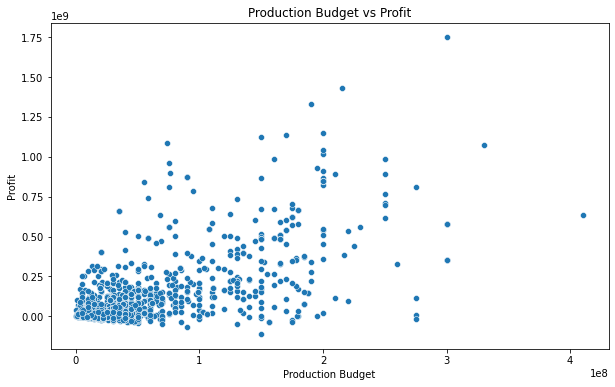

In [52]:
# visualize the production budget vs profit using a scatterplot
plt.figure(figsize=(10,6)) # the size of the figure
sns.scatterplot(x='production_budget', y='profit', data=merged_df) # use seaborn to visualize a scatterplot
plt.title('Production Budget vs Profit') 
plt.xlabel('Production Budget')
plt.ylabel('Profit')
plt.show()

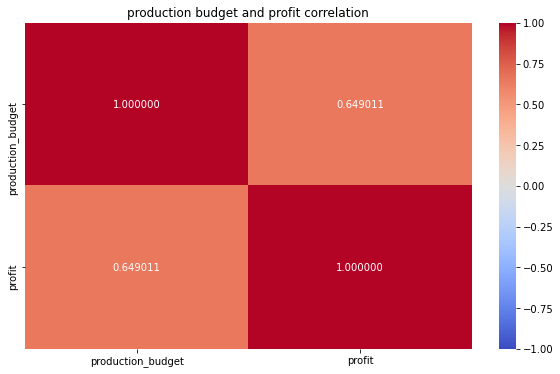

In [53]:
# creates a correlation heatmap
plt.figure(figsize=(10,6)) # size of the figure
corr_hm = merged_df[['production_budget', 'profit']].corr() # calculates pearson correlation co-efficient 
sns.heatmap(corr_hm, annot=True, fmt='f', cmap='coolwarm', vmin=-1, vmax=1) #use seaborn to create a heatmap 
plt.title('production budget and profit correlation')
plt.show()

*Insight*

The heatmap and scatterpot shows the correlation between the production budget and profit and it shows a moderate positive correlation of 0.65. This indicates that larger production budgets are likely to generate high profits, but other factors may come into play, so it does not mean that all high budget movies generate high profit.

*Business Recommendation*

The studio should invest in high budget movies as they are more likely to generate a high profit.

## Objective 4: How do audience ratings relate to performance?  

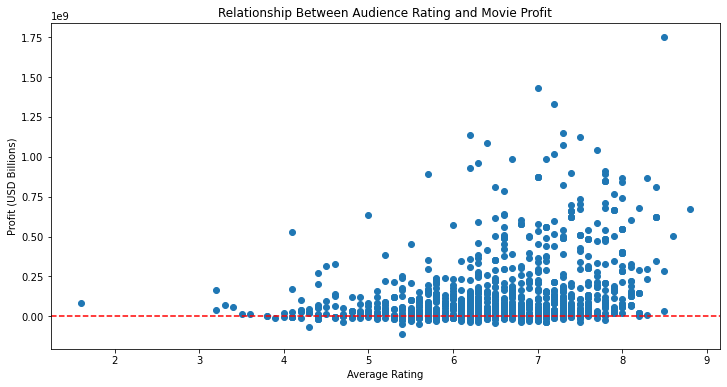

Correlation between rating and profit: 0.300


In [54]:
# Create scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(merged_df['averagerating'], merged_df['profit'])
plt.xlabel('Average Rating')
plt.ylabel('Profit (USD Billions)')
plt.title('Relationship Between Audience Rating and Movie Profit')
plt.axhline(y=0, color='r', linestyle='--') 
#Draws a horizontal reference line at y = 0 (zero profit) in red.
# This helps visually separate profitable vs. loss-making movies.
plt.show()

# Calculate correlation
correlation = merged_df['averagerating'].corr(merged_df['profit'])
print(f"Correlation between rating and profit: {correlation:.3f}")

The Pearson correlation coefficient between a movie’s rating and its profit (revenue − budget) is `0.300`. This is a weak positive relationship. This means that as ratings increase, profits tend to increase slightly, but the relationship is not strong (higher ratings slightly associate with higher profits)

Ratings might help a bit, but other factors (like genre, marketing, or budget) likely play a bigger role in determining profits.

The rating range between 0 and 5 shows many poorly rate movies lost money On average, higher rated movies tend to earn more profit but this is heavily unreliable due to th weak correlation

## 8. Business Recommendations 

1. Bussiness Recomendation Based on Most Expensive Genres

Adventure, Sci-Fi, Fantasy, and Animation movies cost the most to make. Studios should plan bigger budgets for these, but also make some lower-cost movies to reduce risk.

2. Business Recommendation Based on Best Performing Genre:

The studio should prioritize producing Action and Adventure films for maximum box-office potential, but balance the portfolio with Comedy or Animation projects that can deliver steady returns with lower financial risk.

3. Business Recommendation Based on the Link between Production Budget and Profit

The studio should invest in high budget movies as they are more likely to generate a high profit.

4. Business Recommendation Based on the Link between Averaging Rating and Profit

Business stakeholders should not focus on user ratings as it does necessarily translate to higher profits. They should focus on other factors such as production budget and best performing genres.